**After Data Preprocessing**

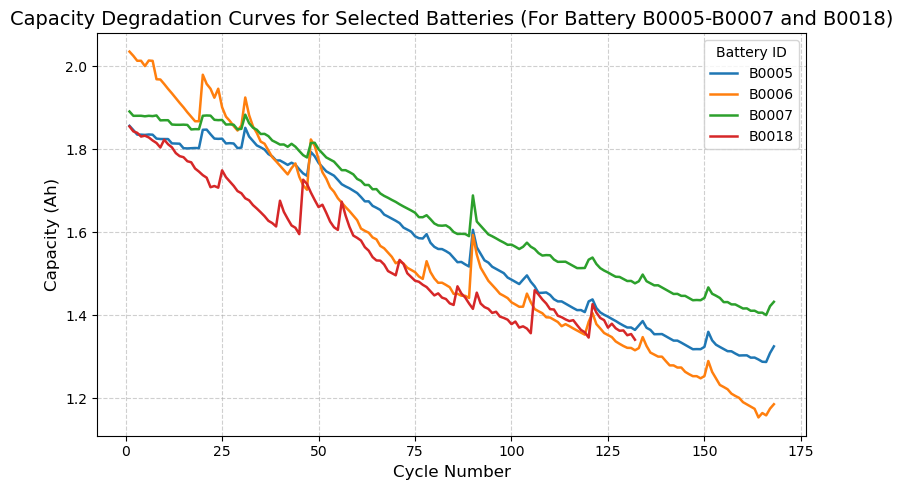

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary.csv"
df = pd.read_csv(path)

# Select the specific batteries
selected_batteries = ["B0005", "B0006", "B0007", "B0018"]

plt.figure(figsize=(8, 5))

# Plot each selected battery
for battery in selected_batteries:
    subset = df[df["battery"] == battery].sort_values("cycle")
    plt.plot(subset["cycle"], subset["capacity_Ah"], label=battery, linewidth=1.8)

plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("Capacity (Ah)", fontsize=12)
plt.title("Capacity Degradation Curves for Selected Batteries (For Battery B0005-B0007 and B0018)", fontsize=14)
plt.legend(title="Battery ID", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


**Linear Regression**

Linear Regression Results (NaN Removed):
R² Score:  0.8879
MAE:       0.1048
RMSE:      0.1520


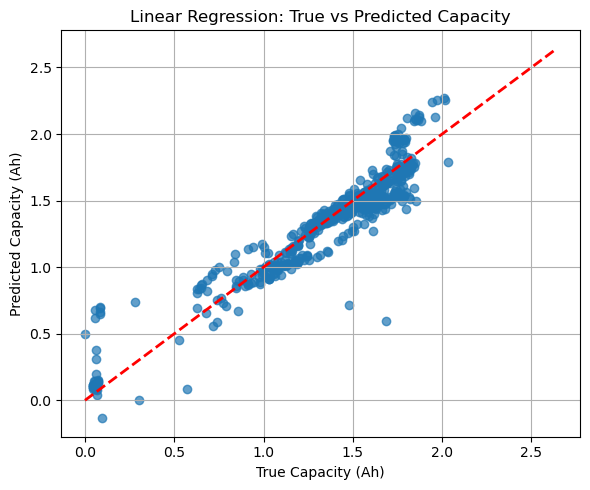

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
path = r"C:\Users\lijun\Downloads\ESE5971-Project\Data\battery_cycles_summary.csv"
df = pd.read_csv(path)

# ===== Drop rows where capacity_Ah is NaN =====
df = df.dropna(subset=["capacity_Ah"])

# ===== Remove unwanted columns =====
drop_cols = ["battery", "capacity_Ah", "RUL"]
X = df.drop(columns=drop_cols, errors="ignore")
y = df["capacity_Ah"]

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

# ===== Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Train model =====
model = LinearRegression()
model.fit(X_train, y_train)

# ===== Evaluate =====
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # ← 这里手动取平方根

print("Linear Regression Results (NaN Removed):")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"RMSE:      {rmse:.4f}")

# ===== Visualization =====
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("True Capacity (Ah)")
plt.ylabel("Predicted Capacity (Ah)")
plt.title("Linear Regression: True vs Predicted Capacity")
plt.grid(True)
plt.tight_layout()
plt.show()
